In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from itertools import chain
import os
from time import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from scipy.optimize import minimize

# Load Real Data

In [2]:
path = "C:/Users/OPTIMUSPRIME/Desktop/Studia/Magisterka/Faints-Prediction/"
BP_filename = "BP.csv"
HR_filename = "HR.csv"

train_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/training_set.txt", header=None).values.tolist()]
test_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/test_set.txt", header=None).values.tolist()]
validation_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/validation_set.txt", header=None).values.tolist()]
all_indices = train_indices + test_indices + validation_indices

In [3]:
BP_data = pd.read_csv(path + "DATA/" + BP_filename, low_memory=False)[all_indices]
HR_data = pd.read_csv(path + "DATA/" + HR_filename, low_memory=False)[all_indices]
labels = {col: BP_data[col].iloc[0] for col in BP_data}

BP_max_value = BP_data.iloc[1:].astype(np.float32).max().max()
BP_min_value = BP_data.iloc[1:].astype(np.float32).min().min()
HR_max_value = HR_data.iloc[1:].astype(np.float32).max().max()
HR_min_value = HR_data.iloc[1:].astype(np.float32).min().min()

BP_scaler = MinMaxScaler().fit(np.array([BP_min_value, BP_max_value]).reshape(-1,1))
HR_scaler = MinMaxScaler().fit(np.array([HR_min_value, HR_max_value]).reshape(-1,1))

BP_data_scaled = BP_data.iloc[1:].astype(np.float32).copy()
BP_data_scaled[all_indices] = BP_scaler.transform(BP_data_scaled[all_indices])


HR_data_scaled = HR_data.iloc[1:].astype(np.float32).copy()
HR_data_scaled[all_indices] = HR_scaler.transform(HR_data_scaled[all_indices])

In [4]:
# SMOOTHING
BP_data_scaled_averaged = BP_data_scaled.rolling(64).mean()
HR_data_scaled_averaged = HR_data_scaled.rolling(64).mean()

# Loading Model

In [5]:
bs = 128
lr = 0.01
stdev = 0.1
e = 5

original_dim = 32
input_shape = (original_dim, )
intermediate_dim = 16
latent_dim = 8

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim), stddev=stdev)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# ENCODER
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
x = BatchNormalization()(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
# encoder.summary()

encoder.load_weights("LINE_DETECTOR_VAE_MLP_RESULTS2/LOSS0.31_DBS4.19_CHS3540.8_LATENT8_STDEV0.1_BS128_E10_LR0.01/encoder/")

# Generate Baseline Data

In [6]:
def generate_line(a, b, n=32, noise=0):
    x = np.arange(n)
    return a * x + b + np.random.normal(0, noise, n)

def generate_lines(a, bs, n_train, c, lines, labels):
    for b in bs:
        generated_lines = np.array([generate_line(a, b, noise=0.005) for _ in range(int(n_train/16))])
        generated_labels = np.array([c for _ in range(int(n_train/16))])
        if lines.size == 0:
            lines = generated_lines
            labels = generated_labels
        else:
            lines = np.concatenate((lines, generated_lines))
            labels = np.concatenate((labels, generated_labels))
    return lines, labels
    
def generate_lines_set(n_train):    
    lines = np.array([])
    labels = np.array([])

    lines, labels = generate_lines(0, [0, .4, .8, 1.2, 1.6, 2], n_train, 'g', lines, labels)
    lines, labels = generate_lines(0.01, [.2, .6, 1, 1.4, 1.8], n_train, 'r', lines, labels)
    lines, labels = generate_lines(-0.01, [.2, .6, 1, 1.4, 1.8], n_train, 'b', lines, labels)

    return np.array(lines), np.array(labels)

n_lines = 64000
n_types = 16
x_train, y_train = generate_lines_set(64000)
x_train = (x_train - np.amin(x_train)) / (np.amax(x_train) - np.amin(x_train))

4000


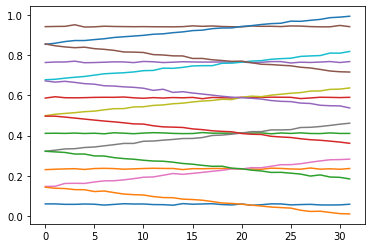

In [7]:
index = 10
interval = int(n_lines / n_types)
print(interval)
while index < n_lines:
    plt.plot(x_train[index])
    index += interval

# Calculate Baseline

In [8]:
z_test, _, _ = encoder.predict(x_train, batch_size=bs)
straight_lines_8D = z_test[:24000]
means = straight_lines_8D.mean(axis=0)
principal_axis = np.linalg.svd(straight_lines_8D - means)[2][0]
baseline_point1 = np.array([0,0,0,0,0,0,0,0], np.float32)
baseline_point2 = np.array(principal_axis, np.float32)

In [9]:
def dist(p, q, rs):
    x = p-q
    return np.linalg.norm(
        np.outer(np.dot(rs-q, x)/np.dot(x, x), x)+q-rs,
        axis=1)

# Visualize 2D

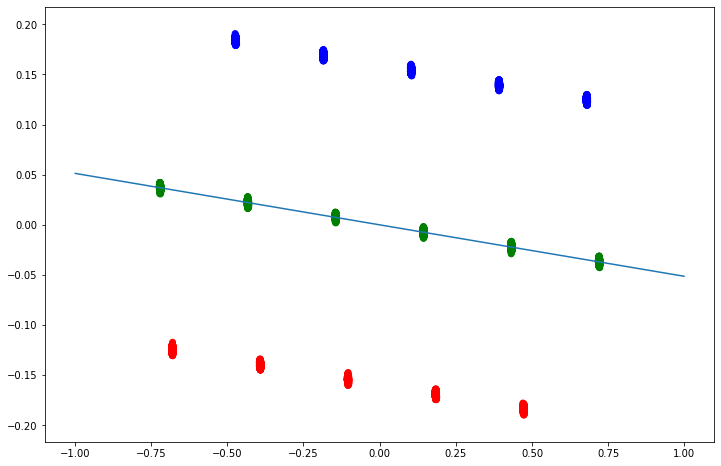

In [10]:
z_test_2D = PCA(n_components=2).fit_transform(z_test)
straight_lines_2D = z_test_2D[:24000]
means_2D = straight_lines_2D.mean(axis=0)
principal_axis_2D = np.linalg.svd(straight_lines_2D - means_2D)[2][0]
baseline_point1_2D = np.array([0,0], np.float32)
baseline_point2_2D = np.array(principal_axis_2D, np.float32)
plt.figure(figsize=(12,8))
plt.scatter(z_test_2D[:, 0], z_test_2D[:, 1],  c=y_train)
plt.plot([-baseline_point2_2D[0], baseline_point2_2D[0]], [-baseline_point2_2D[1], baseline_point2_2D[1]])

# Label Validation Samples

In [26]:
indexes = ['375', '1', '92', '110', '158', '286', '295', '393', '460', '501', '606', '658', '675'] #375 is the longest, that's why it is in the beginning
# indexes = ['375', '393']

In [12]:
def label_func(index, start, end, color):
    for i in range(start, end):
        BP_HR_validation_labels[index][i] = color

BP_HR_validation_labels = dict()
BP_validation = dict()
HR_validation = dict()
for index in indexes:
    BPx = np.array(BP_data_scaled_averaged[index])
    HRx = np.array(HR_data_scaled_averaged[index])
    BPx = BPx[~np.isnan(BPx)]
    HRx = HRx[~np.isnan(HRx)]
    BPx = BPx[:-(BPx.shape[0] % 32)]
    HRx = HRx[:-(HRx.shape[0] % 32)]
    BPxs = np.array(np.array_split(BPx, int(len(BPx)/32)))
    HRxs = np.array(np.array_split(HRx, int(len(HRx)/32)))
    BP_HR_validation_labels[index] = np.array(['g']*len(BPxs))
    BP_validation[index] = BPxs
    HR_validation[index]= HRxs

In [13]:
index = '1'
label_func('1', 80, 81, 'r')
label_func('1', 81, 107, 'r')
label_func('1', 107, 108, 'r')
index = '92' 
label_func('92', 41, 49, 'r')
label_func('92', 142, 143, 'r')
label_func('92', 143, 154, 'r')
index = '110' 
label_func('110', 119, 120, 'r')
label_func('110', 120, 123, 'r')
index = '158' 
label_func('158', 25, 29, 'r')
label_func('158', 115, 116, 'r')
label_func('158', 116, 122, 'r')
label_func('158', 122, 123, 'r')
index = '286' 
label_func('286', 63, 65, 'r')
label_func('286', 65, 67, 'r')
label_func('286', 123, 124, 'r')
label_func('286', 124, 129, 'r')
label_func('286', 129, 131, 'r')
label_func('286', 131, 134, 'r')
index = '295' 
label_func('295', 131, 134, 'r')
label_func('295', 134, 144, 'r')
index = '375'
label_func('375', 40, 47, 'r')
label_func('375', 129, 133, 'r')
label_func('375', 133, 141, 'r')
label_func('375', 141, 144, 'r')
label_func('375', 162, 167, 'r')
index = '393' 
label_func('393', 32, 36, 'r')
label_func('393', 36, 37, 'r')
index = '460' 
label_func('460', 50, 58, 'r')
label_func('460', 58, 59, 'r')
index = '501'
label_func('501', 119, 120, 'r')
label_func('501', 120, 124, 'r')
label_func('501', 124, 125, 'r')
index = '606'
label_func('606', 60, 61, 'r')
label_func('606', 61, 70, 'r')
label_func('606', 70, 72, 'r')
index = '658', 
label_func('658', 36, 53, 'r')
label_func('658', 53, 55, 'r')
index ='675', 
label_func('675', 82, 101, 'r')
label_func('675', 101, 104, 'r')

# Auxiliary Functions

In [14]:
def sample_timeseries(x):
    x = np.array(x)
    x = x[~np.isnan(x)]
    if x.shape[0] % 32 != 0:
        x = x[:-(x.shape[0] % 32)]
    return np.array(np.array_split(x, int(len(x)/32)))


N_SAMPLES_MEMORY = 5
BP_SEVERITY_ACC = np.zeros(N_SAMPLES_MEMORY)
HR_SEVERITY_ACC = np.zeros(N_SAMPLES_MEMORY)
BP_HR_SEVERITY_ACC = np.zeros(N_SAMPLES_MEMORY)

def zero_accumulators():
    global BP_SEVERITY_ACC, HR_SEVERITY_ACC, BP_HR_SEVERITY_ACC
    BP_SEVERITY_ACC = np.zeros(N_SAMPLES_MEMORY)
    HR_SEVERITY_ACC = np.zeros(N_SAMPLES_MEMORY)
    BP_HR_SEVERITY_ACC = np.zeros(N_SAMPLES_MEMORY)
    
def classifier(y_pred, a, b):
    global BP_SEVERITY_ACC, HR_SEVERITY_ACC, BP_HR_SEVERITY_ACC
    BP_anomaly_score = y_pred[-1][0]
    HR_anomaly_score = y_pred[-1][1]
    HR_SEVERITY_ACC = np.append(HR_SEVERITY_ACC, HR_anomaly_score)
    BP_SEVERITY_ACC = np.append(BP_SEVERITY_ACC, BP_anomaly_score)
    BP_HR_SEVERITY_ACC = np.append(BP_HR_SEVERITY_ACC, HR_anomaly_score + BP_anomaly_score)
    if HR_anomaly_score > a or BP_anomaly_score > a or HR_anomaly_score + BP_anomaly_score > a or np.mean(HR_SEVERITY_ACC[-5:]) > b or np.mean(BP_SEVERITY_ACC[-5:]) > b or np.mean(BP_HR_SEVERITY_ACC[-5:]) > b:
        return 'r'
    else:
        return 'g'    

def write_to_file(path, header, *args):
    with open(path, 'a') as file:
        if os.stat(path).st_size == 0:
            file.write(header)
        text = str()
        for item in args:
            text += str(item) + '\t'
        file.write('\n' + text)

def count_samples(timeseries):
    n_of_not_nans = np.count_nonzero(~np.isnan(timeseries))
    return int(n_of_not_nans/32)

def calculate_metrics(direct_threshold, average_threshold, labels_true, labels_pred, write_file):
    class_report = classification_report(labels_true, labels_pred, output_dict=True)
    acc = round(class_report['accuracy'], 4)
    red_f1 = round(class_report['r']['f1-score'], 4)
    red_precision = round(class_report['r']['precision'], 4)
    red_recall = round(class_report['r']['recall'], 4)
    green_f1 = round(class_report['g']['f1-score'], 4)
    green_precision = round(class_report['g']['precision'], 4)
    green_recall = round(class_report['g']['recall'], 4)
    if write_file:
        write_to_file("MLP_best_model_thresholds_grid_search.tsv", 
                      "Direct Threshold\tAveraged Threshold\tAccuracy\tRed F1\tRed Precision\tRed Recall\tGreen F1\tGreen Precision\tGreen Recall",
                      direct_threshold,
                      average_threshold,
                      acc,
                      red_f1,
                      red_precision,
                      red_recall,
                      green_f1,
                      green_precision,
                      green_recall) 
    return red_f1

def evaluate_model(y_pred, direct_threshold, average_threshold, write_file):
    start = time()
    labels_pred = np.array([])
    
    for i in indexes:
        zero_accumulators()
        n_of_samples_in_timeseries = count_samples(BP_data_scaled_averaged[i])
        for j in range(n_of_samples_in_timeseries):   
            severity = classifier(y_pred[i][:j+1], direct_threshold, average_threshold)
            labels_pred = np.append(labels_pred, severity)
    labels_true = np.array(list(chain(*BP_HR_validation_labels.values())), dtype=str)  
    example_metric = calculate_metrics(direct_threshold, average_threshold, labels_true, labels_pred, write_file)
    
    print(f"Red F1: {example_metric:.4f}, DT: {direct_threshold:.3f}, AT: {average_threshold:.3f}, time:{(time() - start):.2f}s")

# Parameters optimization

In [15]:
direct_thresholds = np.array(range(20, 202, 2)) / 1000
average_thresholds = np.array(range(20, 202, 2)) / 1000
print(direct_thresholds)

[0.02  0.022 0.024 0.026 0.028 0.03  0.032 0.034 0.036 0.038 0.04  0.042
 0.044 0.046 0.048 0.05  0.052 0.054 0.056 0.058 0.06  0.062 0.064 0.066
 0.068 0.07  0.072 0.074 0.076 0.078 0.08  0.082 0.084 0.086 0.088 0.09
 0.092 0.094 0.096 0.098 0.1   0.102 0.104 0.106 0.108 0.11  0.112 0.114
 0.116 0.118 0.12  0.122 0.124 0.126 0.128 0.13  0.132 0.134 0.136 0.138
 0.14  0.142 0.144 0.146 0.148 0.15  0.152 0.154 0.156 0.158 0.16  0.162
 0.164 0.166 0.168 0.17  0.172 0.174 0.176 0.178 0.18  0.182 0.184 0.186
 0.188 0.19  0.192 0.194 0.196 0.198 0.2  ]


In [30]:
def calc_predicted_values(BP_data, HR_data, model, baseline_point1, baseline_point2):
    y_pred = dict()
    for i in indexes:
        y_pred_sample = []
        HR_sampled = sample_timeseries(HR_data[i])
        BP_sampled = sample_timeseries(BP_data[i]) 
        n_of_samples_in_timeseries = len(BP_sampled)
        BP_points_8D, _, _ = model.predict(BP_sampled)
        HR_points_8D, _, _ = model.predict(HR_sampled)
        BP_distances = dist(baseline_point1, baseline_point2, BP_points_8D)
        HR_distances = dist(baseline_point1, baseline_point2, HR_points_8D)
        y_pred_sample = np.array([[BP_dist, HR_dist] for BP_dist, HR_dist in zip(BP_distances, HR_distances)])
        y_pred[i] = y_pred_sample
    return y_pred

def grid_search(direct_thresholds, average_thresholds, write_file=False):
    print("Calculating predictions ...")
    y_pred = calc_predicted_values(BP_data_scaled_averaged, HR_data_scaled_averaged, encoder, baseline_point1, baseline_point2)
    print("Calculating predictions done.")
    for direct_threshold in direct_thresholds:
        for average_threshold in average_thresholds:
            evaluate_model(y_pred, direct_threshold, average_threshold, write_file)

# grid_search(direct_thresholds, average_thresholds, True)

# Plotting metrics

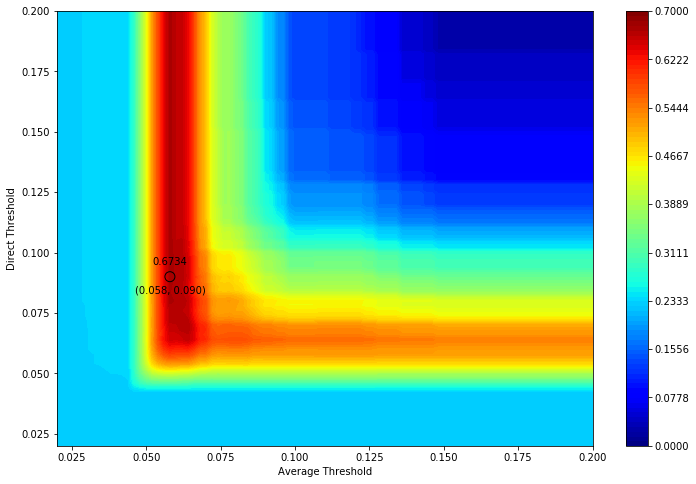

In [21]:
def plot_metric(AA, BB, CC):
    def f(AA, BB):
        C = np.zeros((len(AA), len(BB)))
        for i in range(len(AA)):
            for j in range(len(BB)):
                C[i, j] = CC[(AA[i], BB[j])]
        return C    
    A, B = np.meshgrid(AA, BB)
    C = f(AA, BB)
        
    max_val = np.max(C)
    x, y = np.where(C == max_val)
    max_val_x = A[x[0], x[0]]
    max_val_y = B[y[0], y[0]]
    
    fig, ax = plt.subplots(figsize=(12,8))
    levels = np.linspace(0, 0.7, 91)
    plt.contourf(A, B, C, levels=levels, cmap='jet')
    ax.set_xlabel('Average Threshold')
    ax.set_ylabel('Direct Threshold')
    plt.colorbar()
    ax.scatter([max_val_y], [max_val_x], marker='o', facecolors='none', s=100, edgecolors='black')
    ax.annotate(max_val, (max_val_y - 0.006, max_val_x + 0.005))
    ax.annotate(f'({max_val_y:.3f}, {max_val_x:.3f})', (max_val_y - 0.0118, max_val_x - 0.007))
    plt.savefig('MLP_VAE_heatmap_F1.png')
    
def load_metric_and_plot(file_path, metric_name):
    metrics = pd.read_csv(file_path, delimiter='\t', index_col=False)
    direct_thresholds = sorted(metrics['Direct Threshold'].unique())
    average_thresholds = sorted(metrics['Averaged Threshold'].unique())
    selected_metric = dict()
    for index, row in metrics.iterrows():
        selected_metric[(row['Direct Threshold'], row['Averaged Threshold'])] = row[metric_name]
    plot_metric(direct_thresholds, average_thresholds, selected_metric)

load_metric_and_plot("MLP_best_model_thresholds_grid_search.tsv", "Red F1")

# Save Timeseries Classification

In [32]:
len(BP_data_scaled_averaged['375'])/32

264.875

In [31]:
y_pred = calc_predicted_values(BP_data_scaled_averaged, HR_data_scaled_averaged, encoder, baseline_point1, baseline_point2)

grid_search_results = pd.read_csv("MLP_best_model_thresholds_grid_search.tsv", delimiter='\t', index_col=False)
best_parameters = grid_search_results.loc[grid_search_results['Red F1'] == max(grid_search_results['Red F1'])]
direct_threshold = best_parameters['Direct Threshold'].iloc[0]
average_threshold = best_parameters['Averaged Threshold'].iloc[0]
print(f"Chosen direct threshold: {direct_threshold}\nChosen average threshold: {average_threshold}")
predicted_labels = pd.DataFrame()
counter = 0
for i in indexes:
    counter = counter + 1
    labels = [] 
    zero_accumulators()
    HR = sample_timeseries(HR_data_scaled_averaged[i])
    BP = sample_timeseries(BP_data_scaled_averaged[i])
    n_of_samples = len(BP)
    for j in range(n_of_samples):
        labels.append(classifier(y_pred[i][:j+1], direct_threshold, average_threshold))
    print(len(labels))
    predicted_labels[i] = pd.Series(labels)
    
predicted_labels.to_csv('best_model_best_params_predicted_labels.tsv', sep='\t')

167
116
154
128
127
134
144
45
81
125
83
72
109
Chosen direct threshold: 0.09
Chosen average threshold: 0.057999999999999996
167
116
154
128
127
134
144
45
81
125
83
72
109


<IPython.core.display.Javascript object>


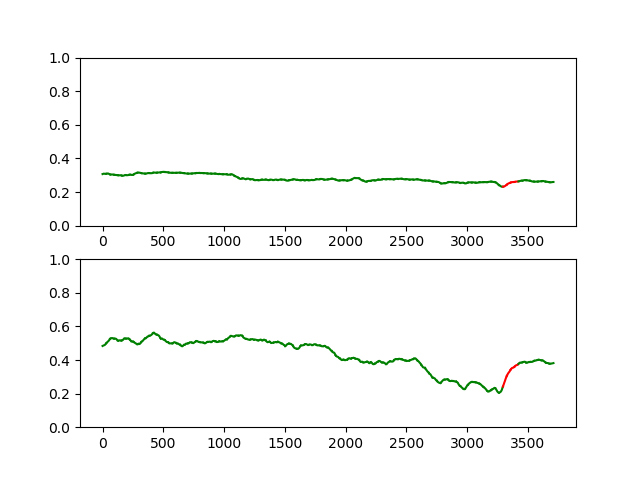

In [82]:
%matplotlib notebook
plt.ion()

n = '1'
HR = sample_timeseries(HR_data_scaled_averaged[n])
BP = sample_timeseries(BP_data_scaled_averaged[n])

# pca = PCA(n_components=2)
# lines_8D, _, _ = encoder.predict(x_train)
# pca.fit(lines_8D)
# lines_2D = pca.transform(lines_8D)

fig1 = plt.figure()
ax1 = fig1.add_subplot(211)
ax1.set_ylim(0,1)
ax2 = fig1.add_subplot(212)
ax2.set_ylim(0,1)
# ax3 = fig1.add_subplot(313)
# ax3.scatter(lines_2D[:, 0], lines_2D[:, 1], c=y_train)
t = 0
severity_acc = np.array([0,0,0])
BP_last_elem = None
for HRv, BPv in zip(HR, BP):
    if BP_last_elem == None:
        BP_line_8D, _, _ = encoder.predict(np.array([BPv]))
        HR_line_8D, _, _ = encoder.predict(np.array([HRv]))
        c = check_severity(HR_line_8D, BP_line_8D, 0.185, 0.060)
#         BP_HR_lines_2D = pca.transform([BP_line_8D[0], HR_line_8D[0]])

        ax1.plot(range(t, t + len(HRv)), HRv, color=f'{c}', linestyle='-')
        ax2.plot(range(t, t + len(BPv)), BPv, color=f'{c}', linestyle='-')
#         ax3.scatter(BP_HR_lines_2D[:, 0], BP_HR_lines_2D[:, 1], c=c)

        t += len(BPv)
    else:
        BP_line_8D, _, _ = encoder.predict(np.array([BPv]))
        HR_line_8D, _, _ = encoder.predict(np.array([HRv]))
        c = check_severity(HR_line_8D, BP_line_8D, 0.185, 0.060)
#         BP_HR_lines_2D = pca.transform([BP_line_8D[0], HR_line_8D[0]])

        time_range = range(t-1, t + len(BPv)) 
        BPv = np.concatenate(([BP_last_elem], BPv))
        HRv = np.concatenate(([HR_last_elem], HRv))
        ax1.plot(time_range, HRv, color=f'{c}', linestyle='-')
        ax2.plot(time_range, BPv, color=f'{c}', linestyle='-')
#         ax3.scatter(BP_HR_lines_2D[:, 0], BP_HR_lines_2D[:, 1], c=c)

        t += len(BPv) - 1
    fig1.canvas.draw()
    BP_last_elem = BPv[-1]
    HR_last_elem = HRv[-1] 